# Exercici AvCont-4(a): Implementació de Compressió LZ-77

**Alumno:** German Dempere Guillermo  
**NIUB:** 16662225

## Ejercicio:

Implementad en Java un compresor/descompresor de datos binarios mediante el algoritmo LZ-77. Debe cumplir las siguientes especificaciones:  

Formato de entrada y salida de datos: String binaria (unos y ceros) de longitud arbitraria.
Posibilidad de configurar a longitud de la Ventana de Entrada (Ment) y Ventana Deslizante (Mdes) variables.
Control de configuración válida; Ment y Mdes deben ser:  
- Potencias de 2
- Ment<=Mdes
- Mdes+Ment<= longitud datos a comprimir
- Formato datos comprimidos: String binaria con
- Cabecera con los primeros “Mdes” bits de los datos de entrada

Almacenar TODAS las coincidencias (L,D) (incluso las de L=1) en formato binario de longitud fija (log2(Ment) + log2(Mdes) bits en total)

**Ejemplo**: si Ment = 4 y Mdes = 8

- (1,1) se guarda como “01 001”
- (2,6) se guarda como “10 110”
- (3,8) se guarda como “11 000”
- (4,5) se guarda como “00 101”


La búsqueda de coincidencias finaliza cuando los bits que quedan por procesar són menos que Ment. En tal caso, guardar estos bits restantes al final de la cadena comprimida.

### Apartados:

1. Comprobad que el programa comprime y descomprime correctamente una cadena de 25 bits aleatorios con Mdes = 8 y Ment = 4.
   <br>*Ayuda: Podéis generar bits aleatorios con Math.round(Math.random())*
2. Utilizad el programa anterior para determinar si es posible, ajustando los valores de Mdes y Ment, conseguir comprimir datos aleatorios mediante LZ77 (es decir, que la cadena de datos originales sea más larga que la cadena comprimida).¿Por qué? ¿Cuál es la máxima compresión que lográis? ¿Con qué valores?
    <br>*Ayuda: utilizad una cadena de datos de entrada de, por lo menos, 10000 bits aleatorios. Ajustad Mdes y Ment entre 2 y 2048).*
    


In [313]:
# Setup
import matplotlib.pyplot as plt
%matplotlib inline

# Utility Functions
DEBUG = False

def debug(*args):
    if DEBUG:
        for arg in args:
            print arg,
        print ""

## Implementacion

### Codificacion LZ77

El primer paso sera implementar la function de compression *lz77*, tomando como parametros 3 entradas:
- El *bitstring* a comprimir
- El tamaño de la ventada de entrada
- El tamaño de la ventana deslizante

Para esta función vamos a abuscar de los indices por offset que ofrece Python.

Como supondremos que los valores de *window* y *lookahead* seran potencias de dos, lo primero que haremos sera
generar nosotros unos strings especiales de formato binario para convertir nuestras tuplas $(l,d)$ a la representacion en bits *zero-padded* que nos permitirá despues descomprimir sin tener que insertar delimitadores para saber cuando empiezan o acaban las tuplas $(l,d)$

**Nota**: En el caso que ningun *string* parcial de la venta de entrada sea encontrado en la ventana deslizante, el codificador no podrá continuar, en tal caso, generará una excepcion. Una solucion es incrementar el tamaño de la ventana de entrada.

In [160]:
def lz77(string, lookahead, win):
    ''' LZ77 compression using a sliding window and a lookahead window'''
    
    if lookahead > win:
        raise Exception("Invalid parameter, lookahead must be <= window")
    
    la_bits = len(bin(lookahead-1)[2:])
    win_bits = len(bin(win-1)[2:])
    la_format = '{0:0%db}' % la_bits
    win_format = '{0:0%db}' % win_bits
    
    debug(la_bits, win_bits)
    
    outstr = string[:win]
    at = win
    
    while at < len(string):
        debug ("================================")
        debug ("at index", at)
        
        winstr = string[at-win:at]
        lookstr = string[at:at+lookahead]
        
        while len(lookstr) > 0 and lookstr not in winstr:
            debug(lookstr, "not found in", winstr)
            lookstr = lookstr[:-1]
            
        # lookstr is either "" or found in window
        if len(lookstr) == 0:
            debug(string[at:at+lookahead], "not partially found in", winstr)
            raise Exception("Can't complete LZ77 encoding, lookahead not found in window")
        
        debug (lookstr, "found in", winstr)
        l = len(lookstr)
        d = win - winstr.index(lookstr)
        
        debug ("len", l, "dist", d)
        
        bl = la_format.format(l-1)
        bd = win_format.format(d-1)
        
        outstr += "(%s,%s)" % (bl,bd)
        at = at + l
        debug ("jump to index", at) 
        
    
    return outstr


DEBUG = False
print lz77("101010", 2, 4)          # expected 1010(1,11)
print lz77("111111111111", 6, 6)    # expected 111111(101,101)



1010(1,11)
111111(101,101)


### Decodificacion LZ77

El segundo paso sera crear la funcion que nos permita traducir la salida de nuestra funcion *LZ77* al bitstring original. Para eso tendremos dos pasos:
1. Insertar todos los bits tal cual del tamaño de la ventana en nuestra salida
1. Procesar los pares de tuplas contra nuestra salida cumulativa

In [192]:

def lz77_decode(string, lookahead, win):
    ''' LZ77 Decoder. Must be supplied with the same parameters as used for the encoding '''
    
    if lookahead > win:
        raise Exception("Invalid parameter, lookahead must be <= window")
    
    la_bits = len(bin(lookahead-1)[2:])
    win_bits = len(bin(win-1)[2:])
    t_bits = la_bits+win_bits
    
    debug ("total bits: ", t_bits)
    
    outstr = string[:win]
    at = win
    while at < len(string):
        debug ("----------------")
        ld = string[at:at+t_bits+3] # +3 chars to account for (,)
        
        # Obtain L, D from their bitstring representations
        l, d = ld[1:-1].split(',')
        l = int(l,2)+1
        d = int(d,2)+1
        
        debug ("at", at)
        debug ("l,d", l,d )
        debug ("len outstr", len(outstr))
        
        # Stand and end offset indices from the end of the current buffer
        # - *start index* is the distance bacl
        # - *end index is*  the distance back plus the lenght
        #
        # in the case of end index = 0, the intepretation is that we have a 0 offset
        # from the back, so we set the end index to None so python does just that
        
        sx = -d
        ex = -d+l
        
        if ex is 0:
            ex = None
            
        debug ("index ", sx, ex)
        
        ref = outstr[sx:ex]
        debug ("ref", ref)
        outstr += ref
        
        at += t_bits+3
        
    return outstr
    
    
win = 16
lah = 8
    
entrada = "111111100001111111110000001111111110000000"

encoded = lz77(entrada, lah, win)

print "entrada    ", entrada
print "codificad  ", encoded

decoded = lz77_decode(encoded, lah, win)

print "decodific  ", decoded

assert entrada == decoded, "encoded and decoded strings DO NOT match!"

entrada     111111100001111111110000001111111110000000
codificad   1111111000011111(111,1100)(111,1110)(111,1110)(001,1111)
decodific   111111100001111111110000001111111110000000


## Set de Pruebas

### Pruebas con Datos Aleatorios

No es demasiado interesante hacer las pruebas, ya que sabemos que los datos de ruido aleatorio tienen una entropia de `1 bit por bit` asi que son incomprimibles, pero por seguir las instrucciones procederemos.

**Nota**: Para facilitar ver los bordes de las tuplas $l,d$ se ha decidido durante el desarrollo mantener los caracters `( , )` en el *string* codificado final. No se usan en ningun momento para saber las *boundaries* de las tuplas $l, d$, y en las metricas de compresión no se tienen en cuenta para calcular la longitud en bits.

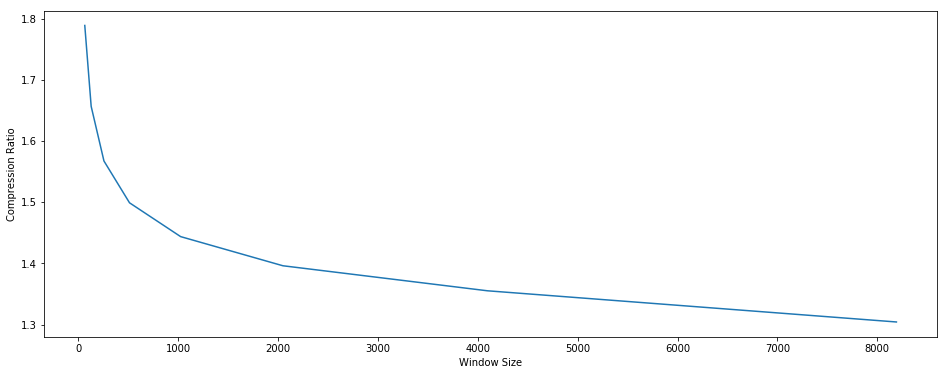

In [337]:
from random import choice

randstr = ""
for i in range(2**16):
    randstr += choice(['0', '1'])

X = []
Y = []
lah = 32
for win_pow in range(6,14):
    win = 2**win_pow
    lz = lz77(randstr, lah, win).replace('(','').replace(')','').replace(',','')

    ratio = len(lz) *1. / len(randstr)
    X += [win]
    Y += [ratio]

plt.figure(figsize=[16,6])
plt.ylabel('Compression Ratio')
plt.xlabel('Window Size')
plt.plot(X,Y)

Como podemos ver en el grafico, la compresion se mantiene por encima de 1 siempre, y tenemos un comportamiento asimtotico hacia un teorico limite de $1$ que no lograriamos alcanzar nunca, excepto en el caso que nuestra ventana sea del mismo tamaño que todos los datos que intentamos comprimir.

### Pruebas con datos Reales

Ya tenemos las dos funciones que realizan la compresion y decompresion de datos binarios. Ahora podemos prodecer a estudiar como afectan los *parametros* de *window* y *lookahead* al factor de compresion.

**Nota**: Para facilitar ver los bordes de las tuplas $l,d$ se ha decidido durante el desarrollo mantener los caracters `( , )` en el *string* codificado final. No se usan en ningun momento para saber las *boundaries* de las tuplas $l, d$, y en las metricas de compresión no se tienen en cuenta para calcular la longitud en bits.

Lo primero que necesitaremos son las funciones de `ASCII -> bits` y de `bits -> ASCII`

In [239]:
def text2bits(text):
    return ''.join(format(ord(x), '07b') for x in text)

def bits2text(bits):
    l = len(bits)
    assert l % 7 == 0, "Number of bits is not multiple of 8. Not ASCII text"
    n = 7
    charcodes = [bits[i:i+n] for i in range(0, len(bits), n)]
    return ''.join([chr(int(code,2)) for code in charcodes])
    
string = "NF(/AGFD)/A&G)/DFGAs46846878d0GAS&/(DGAS&/=)(GDA)/S"
bits = text2bits(string)
assert bits2text(bits) == string, "String and bits to string do not match"

### Lookahead de 16 bits, Window de 2^4 a 2^18

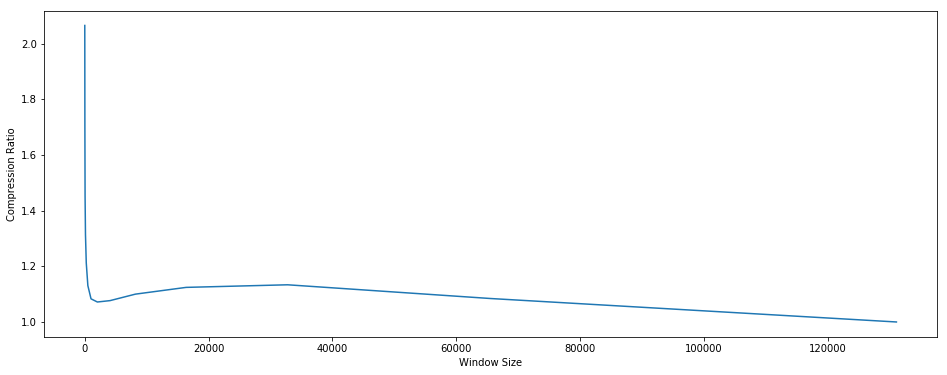

In [336]:
quijote = open('quijote.txt','r').read()
quijote = text2bits(quijote)

X = []
Y = []
lah = 16
for win_pow in range(4,18):
    win = 2**win_pow
    lz = lz77(quijote, lah, win).replace('(','').replace(')','').replace(',','')

    ratio = len(lz) *1. / len(quijote)
    X += [win]
    Y += [ratio]

plt.figure(figsize=[16,6])
plt.ylabel('Compression Ratio')
plt.xlabel('Window Size')
plt.plot(X,Y)

### Lookahead de 32 bits, Window de 2^5 a 2^18

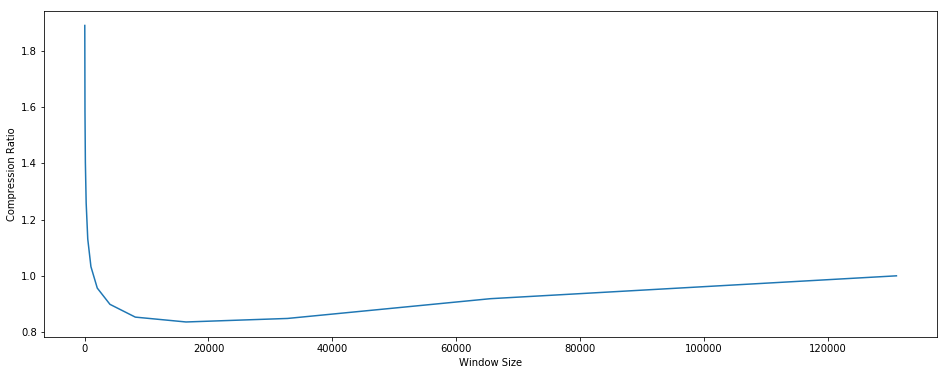

In [339]:
X = []
Y = []
lah = 32
for win_pow in range(5,18):
    win = 2**win_pow
    lz = lz77(quijote, lah, win).replace('(','').replace(')','').replace(',','')

    ratio = len(lz) *1. / len(quijote)
    X += [win]
    Y += [ratio]

plt.figure(figsize=[16,6])
plt.ylabel('Compression Ratio')
plt.xlabel('Window Size')
plt.plot(X,Y)

### Lookahead de 64 bits, Window de 2^6 a 2^18

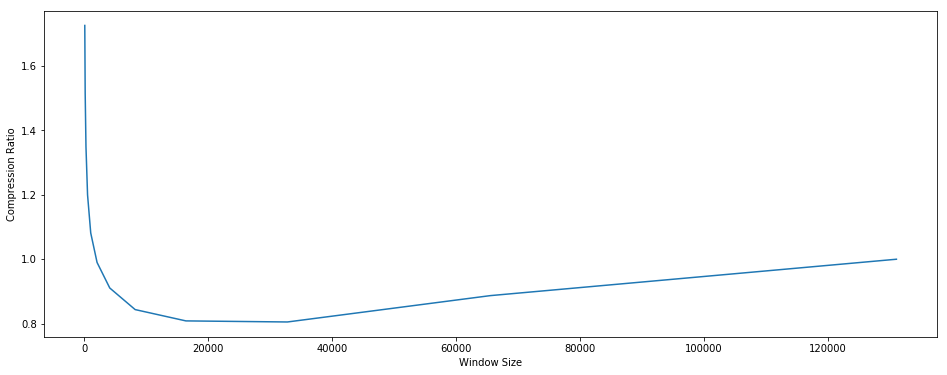

In [341]:
X = []
Y = []
lah = 64
for win_pow in range(6,18):
    win = 2**win_pow
    lz = lz77(quijote, lah, win).replace('(','').replace(')','').replace(',','')

    ratio = len(lz) *1. / len(quijote)
    X += [win]
    Y += [ratio]

plt.figure(figsize=[16,6])
plt.ylabel('Compression Ratio')
plt.xlabel('Window Size')
plt.plot(X,Y)

## Conclusiones de los Gràficos de las Pruebas

Experimentando, hemos descubierto que por regla general *LZ77* funciona mejor para valores muy grandes de *window* y muy pequeños (pero no demasiado) de *lookahead* (ventana de entrada).  

De los graficos podemos extraer las siguientes apreciaciones:

- Para valores de *looakead* muy pequeños (en nuestro caso 16 bits), comprimir por debajo de $1$ es virtualmente imposible.
- Para valores de ventana muy pequeños LZ77 hace **mas grande** un bitstring.
- Existe un valor de ventana $W_0$ donde el ratio de compresion es maximo para un valor *lookahead* $L_a$ dado
- Existe un *efecto rebote* cuando nos alejamos de $W_0$ por los dos lados, perdiendo ratio de compresion a ambos extremos
- Para valores de ventana que abarcan toda la longitud del archivo, el ratio de compresion tiende a $1$